In [12]:
import jax.numpy as np
from jax import value_and_grad, jit
import numpy as onp

import matplotlib.pyplot as plt
%matplotlib inline

In [40]:

###Original softmax:
# @jit
# def softmax(x):
#     x = x + np.diag(np.ones(30)*np.inf)
#     """Compute softmax values for each sets of scores in x."""
#     e_x = np.exp(x - np.max(x))
#     return e_x / e_x.sum()

###Softmax that sets distances to self to -np.inf, meaning the probability goes to zero.
@jit
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp((x - np.diag(np.ones(x.shape[0])*np.inf)) - np.max(x))
    return e_x / e_x.sum()


#E_fn is just a pairwise distance function,
#stole from https://github.com/google/jax/issues/787 .
@jit
def E_fn(conf):
    ri = np.expand_dims(conf, 0)
    rj = np.expand_dims(conf, 1)
    dxdydz = np.power(ri - rj, 2)
    #return squared euclidean:
    dij = np.sum(dxdydz, axis=-1)
    return dij
    
    
@jit
def loss(A, X, y_mask, zero_mask):
    embedding = X.dot(A.T)
    distances = E_fn(embedding)

    
    p_ij = softmax(-distances)
    p_ij_mask = p_ij * y_mask
    p_i = p_ij_mask.sum(1)
    loss = -p_i.sum()
    
    logprobs = np.log(p_i[zero_mask])
    clf_loss = -np.sum(logprobs)

    diff_class_distances = distances * ~y_mask
    hinge_loss = (np.clip(1- diff_class_distances, 0, np.inf)**2).sum(1).mean()
    return clf_loss + hinge_loss


In [42]:
def make_circle(r, num_samples):
  t = onp.linspace(0, 2*np.pi, num_samples)
  xc, yc = 0, 0  # circle center coordinates
  x = r*np.cos(t) + 0.2*onp.random.randn(num_samples) + xc
  y = r*np.sin(t) + 0.2*onp.random.randn(num_samples) + yc
  return x, y


def gen_data(num_samples, num_classes, mean, std):
  """Generates the data.
  """
  num_samples_per = num_samples // num_classes
  X = []
  y = []
  for i, r in enumerate(range(num_classes)):
    # first two dimensions are that of a circle
    x1, x2 = make_circle(r+1.5, num_samples_per)
    # third dimension is Gaussian noise
    x3 = std*onp.random.randn(num_samples_per) + mean
    X.append(onp.stack([x1, x2, x3]))
    y.append(onp.repeat(i, num_samples_per))
  X = np.concatenate(X, axis=1)
  y = np.concatenate(y)
  indices = list(range(X.shape[1]))
  onp.random.shuffle(indices)
  X = X[:, indices]
  y = y[indices]
  X = X.T  # make it (N, D)
  return X, y

a, b = gen_data(1000, 4, 0, 1)

# nesterov momentum:

In [43]:
D = 3
d = 2
A = onp.random.randn(d,D)*0.1
V = np.zeros_like(A)
mass = 0.1
ayze = list()
velocities = list()
lr = 0.0001 #step size

values = list()
for _ in range(300):
    idx = onp.random.choice(range(a.shape[0]), 100, replace=False)
    batch = a[idx]
    labels = b[idx]
    y_mask = (labels[:, None] == labels[None, :])
    zero_mask = onp.array(y_mask.sum(1)==1)
    pos_idx = (~zero_mask).nonzero()[0]
    
    

    value, g = value_and_grad(loss)(A,batch,y_mask, pos_idx)
    values.append(value)
        
    V = mass * V + g
    velocities.append(V)
    ayze.append(A)

    A = A - lr*(mass*V+g)
    print(value)

675.16254
667.40753
667.64764
666.4367
657.14233
656.8387
650.2779
644.7918
647.79156
649.3149
646.4104
645.5119
640.47845
631.8955
642.87695
640.78516
644.4189
645.1032
631.736
632.8537
639.553
634.0689
635.3699
636.25336
636.60767
625.10846
633.1222
631.3013
626.9617
632.6642
625.85034
620.04724
627.6496
620.18774
624.2524
627.71594
632.06757
618.7126
628.6336
616.4111
617.60876
626.03845
617.70435
615.7224
620.631
618.1638
614.6757
619.73315
622.8376
614.6131
614.0631
612.48456
613.1468
609.5572
612.4319
610.6102
613.4878
611.4271
616.111
603.9955
610.75323
606.7027
598.6091
608.58325
601.27515
604.671
607.13245
601.9835
603.6385
604.8516
596.8778
590.71265
598.8366
604.15063
592.24585
595.54156
594.48987
583.7446
596.9533
597.44434
592.9213
588.3957
592.0734
588.4073
588.74445
585.5843
582.87604
589.3155
589.06995
592.0283
589.4207
577.307
593.99207
589.60785
581.41223
586.17017
581.16956
582.6869
584.2984
583.0668
591.3658
580.4849
585.3127
590.3159
577.91315
579.21313
577.7426
57

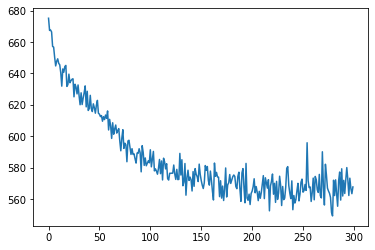

In [44]:
plt.plot(values)

# adadelta

In [32]:
D = 3
d = 2
A = onp.random.randn(d,D)*0.1

g_sq = np.zeros_like(A)
m = np.zeros_like(A)

mass = 1
ayze = list()
g_squares = list()
lr = 0.1 #step size
momentum=0.9

values = list()
for _ in range(300):
    #if _%20==0:
    #    lr = 0.95*lr
    idx = onp.random.choice(range(a.shape[0]), 100, replace=False)
    batch = a[idx]
    labels = b[idx]
    #labels = labels.nonzero()[1]
    y_mask = (labels[:, None] == labels[None, :])
    zero_mask = onp.array(y_mask.sum(1)==1)
    pos_idx = (~zero_mask).nonzero()[0]


    value, g = value_and_grad(loss)(A,batch,y_mask, pos_idx)
    values.append(value)
        
    g_sq += g**2
    g_sq_inv_sqrt = np.where(g_sq > 0, 1. / np.sqrt(g_sq), 0.0)
    m = (1. - momentum) * (g * g_sq_inv_sqrt) + momentum * m
    A = A - lr * m
        
    ayze.append(A)

    print(value)

667.5033
664.751
661.25995
655.6469
644.942
647.5557
636.6235
630.1865
631.91956
625.5818
616.8583
615.1006
620.4551
628.28217
614.9746
616.44366
629.9227
621.89404
611.98334
622.76086
614.4979
624.1852
612.7951
615.5873
617.8592
620.18066
622.4626
607.1469
615.5913
622.03973
616.3955
616.54346
617.0419
614.95703
607.9436
612.5042
610.1686
617.12866
603.9495
607.75397
621.03436
614.0235
621.32837
611.84235
621.21747
615.9341
612.8104
605.7915
611.02563
608.40875
611.5892
611.3748
618.0117
614.2855
613.5882
595.16266
611.01074
629.2862
603.9989
618.3224
602.335
597.6569
596.79266
613.8233
613.6377
588.42676
613.72595
597.8692
600.4875
598.44354
587.4531
586.6846
593.4803
578.90186
588.49304
581.272
578.0958
583.3938
578.32587
575.5445
588.0522
572.8815
580.7427
578.43146
574.8747
576.28015
567.6384
561.68555
572.1033
567.7054
567.5767
560.24457
574.43066
557.2159
589.11224
560.7989
562.52576
561.9938
564.42694
576.2024
609.76135
567.90173
561.6699
561.14215
564.9052
568.39374
553.02155


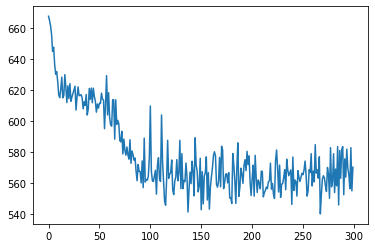

In [33]:
plt.plot(values)

In [19]:
D = 3
d = 2
A = onp.random.randn(d,D)*0.1
avg_sq_grad = np.zeros_like(A)

gamma=0.9
eps=1e-8

mass = 1
ayze = list()
g_squares = list()
lr = 0.001 #step size

values = list()
for _ in range(1000):
    idx = onp.random.choice(range(a.shape[0]), 100, replace=False)
    batch = a[idx]
    labels = b[idx]

    y_mask = (labels[:, None] == labels[None, :])
    zero_mask = onp.array(y_mask.sum(1)==1)
    pos_idx = (~zero_mask).nonzero()[0]
    

    value, g = value_and_grad(loss)(A,batch,y_mask, pos_idx)
    values.append(value)
        
    avg_sq_grad = avg_sq_grad * gamma + g**2 * (1. - gamma)
    A = A - lr * g / np.sqrt(avg_sq_grad + eps)

        
    ayze.append(A)

    print(value)

661.5477
662.516
650.19543
658.1654
656.40173
653.15607
645.0283
652.0977
653.0293
648.4219
654.6503
657.15765
648.32086
653.1332
654.2711
653.392
649.0008
647.3338
650.9544
652.61456
645.7234
649.0066
647.3969
651.1263
648.2617
650.16864
643.1392
648.4059
650.84393
649.50146
646.84845
646.36835
647.0788
639.0555
639.98785
644.8457
649.3819
646.09436
644.4844
639.2386
643.393
644.74115
643.0307
644.9604
639.89526
641.59503
644.052
635.444
634.1997
639.24927
638.5055
637.0466
638.99835
633.20764
638.55536
638.0497
637.36725
635.2283
643.0276
640.3617
638.62573
636.3087
640.5056
640.3357
635.86273
642.0893
641.22906
635.9922
634.97266
635.1688
631.7638
635.55383
634.64496
635.9078
637.68823
634.91974
634.11755
628.5299
633.9984
633.3262
633.3259
634.9334
635.95557
631.1016
636.5203
631.4182
628.4008
629.5197
635.2203
636.3158
634.57355
628.24054
633.1952
631.8073
632.21
627.603
635.6927
632.06604
626.2877
629.2661
630.76013
623.13
623.89014
628.39545
634.4048
630.3298
628.27246
627.68207

575.6035
570.06573
571.854
555.9532
572.98883
570.20166
558.28864
550.5444
559.1697
553.06274
567.8711
570.8163
566.66296
571.9577
576.07404
555.57776
564.08093
554.07904
574.5084
567.89685
562.2476
565.4541
559.824
554.91876
561.82666
569.8035
575.922
567.87555
568.9656
579.0856
556.77716
560.3665
580.4074
565.2924
567.43286
557.3554
554.9052
575.28516
564.33344
556.1276
563.7215
559.2722
576.21063
583.2192
546.4805
571.03015
579.2339
561.65704
577.50824
558.3366
552.36194
559.82935
566.5977
566.88464
553.6443
574.1888
565.0434
559.2742
554.9975
571.7914
555.8105
560.89966
563.7619
568.09393
561.84894
569.29803
565.2979
566.2592
553.45844
550.86914
556.6385
559.5872
581.813
562.2897
573.56036
544.34595
553.88367
573.43896
564.596
567.19147
555.9007
571.84644
559.013
558.48486
565.67017
553.27295
566.09204
572.5196
567.9273
559.3059
556.1113
564.5628
555.4229
572.04144
568.2702
552.2391
554.70074
556.3742
568.6055
562.786
558.46606
582.20087
558.6915
572.4344
556.35736
589.6402
576.721

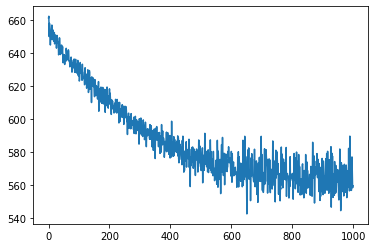

In [20]:
plt.plot(values)

# plot:

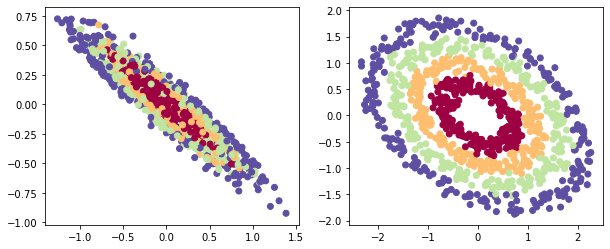

In [25]:
fig, ax = plt.subplots(1,2)

fig.set_figwidth(10)
emb = a.dot(ayze[0].T)
ax[0].scatter(emb[:,0], emb[:,1], c=b, cmap='Spectral')

emb = a.dot(ayze[200].T)
ax[1].scatter(emb[:,0], emb[:,1], c=b, cmap='Spectral')

# save as gif:

In [ ]:
def update_plot(i, data, scplot):
    
    A = data[i]
    emb = a.dot(A.T)
    
    scplot.set_offsets(emb)
    ax.set_xlim(emb[:,0].min()+0.1*emb[:,0].min(), emb[:,0].max()+0.1*emb[:,0].max())
    ax.set_ylim(emb[:,1].min()+0.1*emb[:,1].min(), emb[:,1].max()+0.1*emb[:,1].max())
    
    return (scplot,)

emb = a.dot(ayze[0].T)
xp = emb[:,0]
yp = emb[:,1]

fig, ax = plt.subplots()
ax.set_xticklabels([])
ax.set_yticklabels([])

scplot = ax.scatter(xp, yp, c=b, cmap='Spectral')

ani = animation.FuncAnimation(fig, update_plot, frames=1000,
                                  fargs=(ayze, scplot), blit=True)
ani.save('./animation.gif', writer='imagemagick', fps=20)